In [1]:
import os
import cv2
import sys
import random
import numpy as np


In [46]:
class Eigenfaces(object):                                                       # *** COMMENTS ***
    faces_count = 2

    faces_dir = '.'                                                             # directory path to the AT&T faces

    l = (400)                                      # training images count
    m = 92                                                                      # number of columns of the image
    n = 112                                                                     # number of rows of the image
    mn = m * n                                                                  # length of the column vector
    
    def __init__(self, _energy = 0.85):
        print('> Initializing started')

        self.energy = _energy
        self.training_ids = []                                                  # train image id's for every at&t face

        L = np.empty(shape=(self.mn, self.l), dtype='float64')                  # each row of L represents one train image


        test_images = []
        labels = []

        i = 0
        a = 0            
        for imgfolder in os.listdir('./Bioid/'):
            for filename in os.listdir('./Bioid/' + imgfolder):
                filename = './Bioid/' + imgfolder + '/'+ filename
                if (filename.lower().endswith(('.png', '.jpg', '.jpeg','.pgm'))):
                    img=cv2.imread(filename,0)

                    img = cv2.resize(img, (92,112), interpolation = cv2.INTER_AREA)

                    img_col = np.array(img, dtype='float64').flatten()              # flatten the 2d image into 1d

                    L[:, i] = img_col[:]                                      # set the cur_img-th column to the current training image
                    
                    i += 1
                    #L[:, i] = img_col[:]
                    #i+=1

                                           

        self.mean_img_col = np.sum(L, axis=1) / self.l                          # get the mean of all images / over the rows of L

        for j in range(0, self.l):                                             # subtract from all training images
            L[:, j] -= self.mean_img_col[:]

        C = np.matrix(L.transpose()) * np.matrix(L)                             # instead of computing the covariance matrix as
        C /= self.l                                                             # L*L^T, we set C = L^T*L, and end up with way
                                                                                # smaller and computentionally inexpensive one
                                                                                # we also need to divide by the number of training
                                                                                # images

        self.evalues, self.evectors = np.linalg.eig(C)                          # eigenvectors/values of the covariance matrix
        sort_indices = self.evalues.argsort()[::-1]                             # getting their correct order - decreasing
        self.evalues = self.evalues[sort_indices]                               # puttin the evalues in that order
        self.evectors = self.evectors[sort_indices]                             # same for the evectors

        evalues_sum = sum(self.evalues[:])                                      # include only the first k evectors/values so
        evalues_count = 0                                                       # that they include approx. 85% of the energy
        evalues_energy = 0.0
        for evalue in self.evalues:
            evalues_count += 1
            evalues_energy += evalue / evalues_sum

            if evalues_energy >= self.energy:
                break

        self.evalues = self.evalues[0:evalues_count]                            # reduce the number of eigenvectors/values to consider
        self.evectors = self.evectors[0:evalues_count]

        self.evectors = self.evectors.transpose()                               # change eigenvectors from rows to columns
        self.evectors = L * self.evectors                                       # left multiply to get the correct evectors
        norms = np.linalg.norm(self.evectors, axis=0)                           # find the norm of each eigenvector
        self.evectors = self.evectors / norms                                   # normalize all eigenvectors

        self.W = self.evectors.transpose() * L                                  # computing the weights

        print('> Initializing ended')

        
    def classify(self, img):
        #img = cv2.imread(path_to_img, 0)

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.equalizeHist(gray)

        
        img = cv2.resize(img,(92, 112), interpolation = cv2.INTER_AREA)                                       # read as a grayscale image
        img_col = np.array(img, dtype='float64').flatten()                      # flatten the image
        img_col1=img_col
        img_col -= self.mean_img_col                                            # subract the mean column
        img_col2 = img_col
        img_col = np.reshape(img_col, (self.mn, 1))                             # from row vector to col vector
        img_col3 =img_col
        
        S = self.evectors.transpose() * img_col                                 # projecting the normalized probe onto the
                                                                                # Eigenspace, to find out the weights
        diff = self.W - S                                                       # finding the min ||W_j - S||

        norms = np.linalg.norm(diff, axis=0)

        closest_face_id = np.argmin(norms)                                     # the id [0..240) of the minerror face to the sample
        return closest_face_id,norms

In [47]:
def draw_rects(img, x1, y1, x2, y2, color):
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

In [48]:
if __name__ == "__main__":
    efaces = Eigenfaces()                                       # create the Eigenfaces object with the data dir

> Initializing started
> Initializing ended


True
331
4369.821866264168


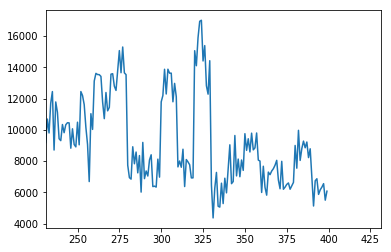

In [49]:
    import matplotlib.pyplot as plt
        
    
    imgliv = cv2.imread('./ben2.jpg')
    liv,norms = efaces.classify(imgliv)
    print(liv<391)
    print(liv)
    print(norms[liv])
    plt.plot(norms)
    plt.xlim(liv-100,liv+100)
    plt.show()
    #cv2.imshow('facedetect', imgliv)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()


In [70]:
    cam = cv2.VideoCapture('./video.mpg')
    while True:
        
        ret, img = cam.read()
        import time
        start = time.time()

        #img = cv2.imread('./portrait.jpg')


        height, width, channels = img.shape
        
        div = int(width/100)

        vis = cv2.resize(img,(int(width/div), int(height/div)), interpolation = cv2.INTER_AREA)
        height, width, channels = vis.shape

        x = 92
        y = 112

        nom=[]
        xy = []
        for i in range(4):
            w = 0
            for a in range(width):
                h = 0
                if((w + x)>width):
                    break
                for b in range(height):
                    if((h + y)>height):
                        break
                    temp = vis[h : h + y, w : w + x]
                    liv,norms = efaces.classify(temp)
                    nom.append(norms[liv])
                    xy.append([h*div,y*div,w*div,x*div])
                    h += 5

                w += 5
            x -= 20
            y -= 24

        done = time.time()
        elapsed = done - start
        #print(elapsed)
        nom = np.array(nom)
        low = (nom <4000).nonzero()

        for l in low[0]:
            h,y,w,x=xy[l]
            draw_rects(img, w,h,w + x,h + y, (255,255,255))

        cv2.imshow('facedetect', img)
        #cv2.waitKey(0)
        if 0xFF & cv2.waitKey(5) == 27:
            break
    cv2.destroyAllWindows()

    #plt.plot(nom)
    #plt.show()
